In [29]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import glob # lista di files in formato *.estensione
import matplotlib.pyplot as plt
import os
import seaborn as sns

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
import tqdm
from scipy.fftpack import fft

In [31]:
X = pd.read_pickle("X-2s.pkl")
X = X.drop("user", axis=1)
y = pd.read_pickle("y-2s.pkl")
espl = pd.read_pickle("espl.pkl")

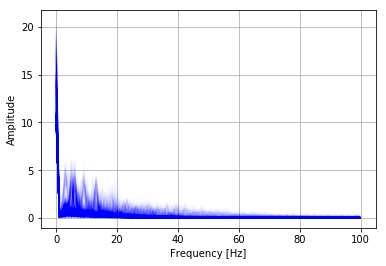

In [32]:
T = 10*0.001  # sampling interval 
N = 200
fftX = pd.DataFrame(fft(X))
#create new x-axis: frequency from signal
xf = np.linspace(0.0, 1.0/T, N//2)
#plot results
for i in range(fftX.shape[0]):
    plt.plot(xf, np.abs(fftX.loc[i,0:N//2-1]) * 1/N, color="blue", alpha=0.007, solid_capstyle="butt")

plt.xlabel("Frequency [Hz]")
plt.ylabel("Amplitude")
plt.grid()

In [33]:
espl

,intTrapz,maxA,MVDeriv,meanA
0,19482.697771,17.934078,0.001180,9.779379
1,20512.653253,19.667330,0.001624,10.317396
2,20261.991579,19.026058,0.001361,10.181171
3,21138.904614,19.894349,0.001560,10.624781
4,19421.826809,17.777913,0.001311,9.766651
5,19947.170332,20.315771,0.001186,10.033285
6,20802.189717,18.496067,0.001046,10.454724
7,20209.539195,19.267323,0.001833,10.155843
8,19784.960222,18.260932,0.001009,9.942053
9,19330.731051,19.615334,0.000821,9.699651


In [34]:
fftX = fftX.abs()
#fftX["intTrapz"] = espl["intTrapz"]
#fftX["maxA"] = espl["maxA"]
#fftX["MVDeriv"] = espl["MVDeriv"]
#fftX["meanA"] = espl["meanA"]
fftX.head()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,1955.875769,88.794430,48.690700,438.685380,165.839638,175.864232,104.737246,54.484093,47.977668,3.663666,...,72.811617,3.663666,47.977668,54.484093,104.737246,175.864232,165.839638,438.685380,48.690700,88.794430
1,2063.479194,41.734938,179.139405,465.910091,122.297157,145.792097,51.748627,89.736656,101.205049,20.350291,...,83.706778,20.350291,101.205049,89.736656,51.748627,145.792097,122.297157,465.910091,179.139405,41.734938
2,2036.234219,53.797712,199.801404,239.772443,365.269511,83.623674,86.638467,47.709146,60.603495,56.115239,...,45.186700,56.115239,60.603495,47.709146,86.638467,83.623674,365.269511,239.772443,199.801404,53.797712
3,2124.956287,108.026773,73.125225,371.609098,355.563671,193.091596,60.335787,117.313886,55.479581,43.712058,...,36.756853,43.712058,55.479581,117.313886,60.335787,193.091596,355.563671,371.609098,73.125225,108.026773
4,1953.330139,108.644806,197.417317,332.312415,308.545240,152.699096,43.684072,124.166926,70.156650,28.510189,...,8.422286,28.510189,70.156650,124.166926,43.684072,152.699096,308.545240,332.312415,197.417317,108.644806


In [35]:
from funzioni import indice_gini
from funzioni import tasso_errata_classificazione
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import graphviz

In [36]:
X_train, X_val, y_train, y_val = train_test_split(fftX, y, test_size=0.25, random_state=42)

In [37]:
dtc = Pipeline([ 
    ("tree", DecisionTreeClassifier(random_state=42))
])

dtc.fit(X_train, y_train)

y_pred = dtc.predict(X_val)
dtc_acc = accuracy_score(y_val, y_pred)

#print('Accuratezza DummyClassifier("most_frequent"): {:.1f}%'.format(100 * dc_acc))
print("Accuratezza DecisionTreeClassifier(): {:.2f}%".format(100 * dtc_acc))
sns.heatmap(confusion_matrix(y_val, y_pred), xticklabels=y.unique(), yticklabels=y.unique())
plt.xticks(np.arange(len(y.unique()))+0.3, y.unique(), rotation=60)
plt.show()

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [ ]:
from sklearn.model_selection import ParameterGrid
import tqdm

In [ ]:
param_grid = ParameterGrid({
    'tree__max_depth': np.arange(1, dtc.named_steps["tree"].tree_.max_depth),
    'tree__min_samples_leaf': 2 ** np.arange(9),
})
print(param_grid.param_grid)

In [ ]:
risultati = []

for params in tqdm.tqdm(param_grid):
    dtc.set_params(**params)
    dtc.fit(X_train, y_train)
    y_pred = dtc.predict(X_val)
    params["accuracy_score"] = accuracy_score(y_val, y_pred)
    risultati.append(params)

risultati = pd.DataFrame(risultati).sort_values(["accuracy_score", "tree__max_depth"], ascending=[False, True])
risultati.reset_index(drop=True, inplace=True)
print("Primi 5:")
display(risultati.head())

print("Ultimi 5:")
risultati.tail()

In [ ]:
from funzioni import grafico_metrica_iperparametro

In [ ]:
max_depth = risultati.loc[0, "tree__max_depth"]
min_samples_leaf = risultati.loc[0, "tree__min_samples_leaf"]

dtc_tun = Pipeline([
    ("tree", DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=42))
])

dtc_tun.fit(X_train, y_train)

y_pred = dtc_tun.predict(X_val)
dtc_tun_acc = accuracy_score(y_val, y_pred)

#print('Accuratezza DummyClassifier("most_frequent"): {:.1f}%'.format(100 * dc_acc))
print("Accuratezza DecisionTreeClassifier(): {:.1f}%".format(100 * dtc_acc))
print("Accuratezza DecisionTreeClassifier(max_depth={}, min_samples_leaf={}): {:.1f}%".format(
    max_depth, min_samples_leaf, 100 * dtc_tun_acc))